# Model 12: Historical dynamics

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model12.html

## Note
- While Model 11 was all about how cooperation emerges within groups, in Model 12 we will zoom out to examine how cooperation, specifically the mechanism of cultural group selection, can determine broader historical dynamics at the level of the group and above.
- In particular, we are interested in how large multi-group societies, or empires, rise and fall throughout human history.
    - The rise and fall of empires is a standard historical pattern.
    - These dynamics are also often described as chaotic, in that it is virtually impossible to predict at any one time point exactly which empires will subsequently grow or collapse.
    - Nevertheless, the overall dynamics of multiple co-existing, competing states going through cycles of emergence, dominance and collapse are worthy of explanation.
- [Turchin (2003)](https://press.princeton.edu/books/hardcover/9780691116693/historical-dynamics) presented a cultural evolutionary theory of how empires rise and fall through human history.
    - Turchin’s theory drew on the notion of cultural group selection (see Model 11), but combined this with historical detail concerning the various pressures acting on real empires from history.
    - In Model 12 we will recapitulate the spatially explicit agent-based simulation of this theory from Chapter 4 of [Turchin (2003)](https://press.princeton.edu/books/hardcover/9780691116693/historical-dynamics).
- One key element of the theory of historical dynamics is the concept of **asabiya**.
    - Asabiya: The degree of within-group cooperation, or collective solidarity, possessed by a group.
- A second key element is the importance of frontier regions.
    - These are regions where different empires or groups of different ethnicities meet.
    - Turchin argues that asabiya is highest at these frontiers because of the presence and threat of competing groups.
    - As modern day examples, religious beliefs tend to be stronger in regions like Northern Ireland or the Middle East where different competing religions exist in close proximity, compared to more religiously homogenous regions.
- Turchin’s theory works as follows.
    - In frontier regions, small groups high in asabiya engage in frequent intergroup conflict.
    - Eventually one of these groups expands and takes over rival groups, becoming a multi-group empire.
    - As this empire expands, its internal non-frontier region gets larger, causing the empire’s overall asabiya to drop.
    - At the frontiers, new groups emerge that are high in asabiya.
    - One of these grows big enough to invade the previous empire, which is weakened by its low asabiya.
    - The new empire thus replaces the old empire.
    - The new empire grows larger, its asabiya drops, and it in turn is invaded by a new empire that has emerged at its frontier.
    - This cycle continues, generating the oscillatory dynamics characteristic of real human history.

## Model

### 0. Setup

- The agents in Model 12 are groups.
- Individuals within groups are not explicitly modelled.
- Each group exists in one fixed position within an  $N_{side} \times N_{side}$ square grid (not torus, Neumann neighborhood).
    - R: data[row, column]
    - Julia: data[column, row]
- Groups can either be independent entities existing outside of any empire, or they can belong to an empire.
- Each empire is denoted by a number, e.g. Empire 1, Empire 2 and so on.
- We use a matrix called $E$ to store the empire id of each group:
    - 0 indicates no empire, a positive integer indicates an empire.

In [1]:
using DataFrames
using Random
using Statistics
using Plots
using Plots.PlotMeasures

using Test: @testset, @test

In [2]:
function setup(N_side::Int)::Tuple{Matrix, Matrix, DataFrame}
    E = fill(0, N_side, N_side)

    # create a starting 4x4-cell empire 1
    row_E1 = rand(3:(N_side - 5))
    col_E1 = rand(3:(N_side - 5))
    E[col_E1:(col_E1+3), row_E1:(row_E1+3)] .= 1

    # matrix for asabiya, S
    S = fill(0.1, N_side, N_side)

    # record area of empires in output dataframe
    output_df = DataFrame(generation = Int[], empire = Int[], area = Int[])
    for empire_label in sort(unique(E))
        push!(output_df, [1, empire_label, count(==(empire_label), E)])
    end

    return E, S, output_df
end;

In [3]:
@testset "setup" begin
    E, S, output = setup(17)
    @test size(E) == size(S) == (17, 17)
    @test maximum(E) == 1
    @test count(==(1), E) == 16
    @test S == fill(0.1, 17, 17)
    @test size(output) == (2, 3)
    @test Vector(output[1, :]) == [1, 0, 17*17-16]
    @test Vector(output[2, :]) == [1, 1, 16]
end

Test Summary: | Pass  Total  Time
setup         |    7      7  0.5s


Test.DefaultTestSet("setup", Any[], 7, false, false, true, 1.681964016768593e9, 1.681964017263127e9)

### 1. Update asabiya

- Groups that have at least one neighbour to the north, south, east or west which belongs to a different empire increase in asabiya.
- Groups with no dissimilar neighbours decrease in asabiya.
- The asabiya of groups with at least one dissimilar neighbourThe asabiya of groups with at least one dissimilar neighbour increases according to the following equation:
    - $S_t = S_{t-1} + r_0 S_{t-1} (1 - S_{t-1})$.
    - This describes logistic (S-shaped) growth in asabiyaThis describes logistic (S-shaped) growth in asabiya.
- The asabiya of groups with no dissimilar neighboursThe asabiya of groups with no dissimilar neighbours decreases according to the following equation:decreases according to the following equation:
    - $S_t = S_{t-1} - \delta S_{t-1}$
    - This describes exponential decline with $\delta$ determining the rate of decline.
    - Exponential decline represents the intrinsic evolutionary advantage of free-riding relative to cooperation:
        - once some free-riders are present, cooperation quickly declines as cooperators refuse to be exploited by those free-riders.
- You are free to change these assumptions to see how robust the results are to different assumptions, or to better fit the evidence.

In [4]:
function update_asabiya!(
    S::Matrix{Float64},  # Matrix of asabiya
    E::Matrix{Int},      # Matrix of empire label
    r_0::Float64,        # increase asabiya according to r_0
    δ::Float64           # decrease asabiya according to δ
)::Nothing
    rows, cols = size(E)

    h_filler = fill(0, 1, cols)
    v_filler = fill(0, rows, 1)

    # Identify borders:
    ## matrix of whether group has at least one dissimilar-empire neighbour
    dissimilar_neighbour = fill(0, size(E))
    ## south:
    dissimilar_neighbour .+= vcat(abs.(E[1:rows-1, :] .- E[2:rows, :]), h_filler)
    ## north:
    dissimilar_neighbour .+= vcat(h_filler, abs.(E[1:rows-1, :] .- E[2:rows, :]))
    ## east:
    dissimilar_neighbour .+= hcat(abs.(E[:, 1:cols-1] .- E[:, 2:cols]), v_filler)
    ## west
    dissimilar_neighbour .+= hcat(v_filler, abs.(E[:, 1:cols-1] .- E[:, 2:cols]))
    ## remove the multiple borders
    dissimilar_neighbour = dissimilar_neighbour .> 0
    
    # Update asabiya
    ## increase S of groups with dissimilar neighbours according to r_0
    S[dissimilar_neighbour] .+= r_0 .* S[dissimilar_neighbour] .* (1 .- S[dissimilar_neighbour])
    ## decrease S of groups without dissimilar neighbours according to delta
    S[.!dissimilar_neighbour] .-= δ .* S[.!dissimilar_neighbour]

    return
end;

In [5]:
# Quick check
E, S, _ = setup(8)
r_0 = 0.2
δ = 0.1

display(E)
display(S)
update_asabiya!(S, E, r_0, δ)
display(S)

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  1  1  1  1  0  0
 0  0  1  1  1  1  0  0
 0  0  1  1  1  1  0  0
 0  0  1  1  1  1  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

8×8 Matrix{Float64}:
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1

8×8 Matrix{Float64}:
 0.09  0.09   0.09   0.09   0.09   0.09   0.09   0.09
 0.09  0.09   0.118  0.118  0.118  0.118  0.09   0.09
 0.09  0.118  0.118  0.118  0.118  0.118  0.118  0.09
 0.09  0.118  0.118  0.09   0.09   0.118  0.118  0.09
 0.09  0.118  0.118  0.09   0.09   0.118  0.118  0.09
 0.09  0.118  0.118  0.118  0.118  0.118  0.118  0.09
 0.09  0.09   0.118  0.118  0.118  0.118  0.09   0.09
 0.09  0.09   0.09   0.09   0.09   0.09   0.09   0.09

### 2. Intergroup conflict

- Each non-edge group is chosen once per generation in a random order to potentially attack their neighbouring groups.
- The chosen attacker cycles through each of its Neumann neighbours again in a random order.
- For each neighbour which is of a different empire to the attacker, we compare the power $P$ of the attacker and the defender.
- The power $P$ of group $x$ which belongs to empire $y$ is given by:
    - $P_x = A_y \bar{S}_y exp(\frac{- d_{x,y}}{h})$
        - $A_y$: the size in number of groups of empire $y$.
        - $\bar{S}_y$: the mean asabiya of all groups belonging to empire $y$.
        - $d_{x,y}$: the Euclidean distance from group $x$ to the centre of empire $y$.
            - The centre of an empire is calculated by taking the mean row number and mean column number of all groups belonging to empire $y$.
        - $h$: constant.
    - For nonempire groups, who are essentially a mini-empire of one group, $A_y = 1$, $\bar{S}_y = \bar{S}_x$, and $d_{x,y} = 0$.
- This equation says that the power of a group increases with the size and average asabiya of its parent empire, and declines with its distance from the centre of the empire.
- Once the power of both attacker, $P_{att}, and defender, $P_{def}, are calculated, their difference is compared against a threshold $\delta_P$:
    - $P_{att} − P_{def} > \delta_P$ 
    - If this inequality is satisfied, then the attacker successfully defeats the defender.
    - If not, then nothing happens.
    - If an attack is successful, the defender joins the empire of the attacker, and the defender’s asabiya $S$ is set to the mean of its previous $S$ and the attacker’s $S$.
    - If the attacker is a nonempire group ($E = 0$), then a new empire forms with a new label $max\_empire + 1$.

In [6]:
function calc_power(E::Matrix{Int}, S::Matrix{Float64}, row::Int, col::Int, h::Float64)::Float64
    # non-empire cells have area A = 1, their own S, and d = 0
    A_value = 1  # the size of group
    S_value = S[row, col]
    d_value = 0.0  # the Euclidean distance from group to the centre of empire

    if E[row, col] > 0
        empire_label = E[row, col]
        empire_members = findall(E .== empire_label)
        row_centre = mean(getindex.(empire_members, 1))
        col_centre = mean(getindex.(empire_members, 2))

        A_value = count(==(empire_label), E)
        S_value = mean(S[E .== empire_label])
        d_value = sqrt((row - row_centre)^2 + (col - col_centre)^2)
    end

    return A_value * S_value * exp(-d_value / h)
end

function intergroup_conflict!(
    E::Matrix{Int},      # Matrix of empire label
    S::Matrix{Float64},  # Matrix of asabiya
    h::Float64,          # rate of decline in power with distance from empire centre
    δ_P::Float64         # threshold for difference in power between attacker and defender
)::Nothing
    rows, cols = size(E)

    # each non-edge cell is chosen in random order to attack their NSEW neighbouring cells
    attackers = [(row, col) for row in 2:rows-1 for col in 2:cols-1]

    for attacker in shuffle(attackers)
        # random order of NSEW neighbours to attack
        for offset in shuffle([(-1, 0), (1, 0), (0, -1), (0, 1)])
            defender = attacker .+ offset
            # if defender is a valid opponent and attacker and defender are of different empires, or both are non-empires
            if defender in attackers && (E[attacker...] != E[defender...] || E[attacker...] == E[defender...] == 0)
                P_att = calc_power(E, S, attacker..., h)
                P_def = calc_power(E, S, defender..., h)

                # if P_att - P_def is greater than delta_P, then attack is successful
                if P_att - P_def > δ_P
                    # if attacker is already part of an empire
                    if E[attacker...] > 0
                        E[defender...] = E[attacker...]
                    # if attacker is a nonempire cell
                    else
                        E[attacker...] = maximum(E) + 1
                        E[defender...] = maximum(E) + 1
                    end

                    # defender adopt the average of their prior S and the attacker's S
                    S[defender...] = (S[attacker...] + S[defender...]) / 2
                end
            end
        end
    end

    return
end;

In [7]:
@testset "calc_power" begin
    E = [0 0; 1 1]
    S = [0.1 0.2; 0.3 0.4]
    h = 2.0

    @test calc_power(E, S, 1, 1, h) == 1 * 0.1 * exp(-0.0 / h) == 0.1
    @test calc_power(E, S, 1, 2, h) == 1 * 0.2 * exp(-0.0 / h) == 0.2

    a = count(==(1), E)
    s = (0.3 + 0.4) / 2
    d = sqrt((1 - 1)^2 + (1 - 0.5)^2)
    @test calc_power(E, S, 2, 1, h) == a * s * exp(-d / h) == 0.5451605481499834
    @test calc_power(E, S, 2, 2, h) == a * s * exp(-d / h) == 0.5451605481499834
end

# Quick check
E, S, _ = setup(9)
h = 2.0
δ_P = 0.1
display(E)
intergroup_conflict!(E, S, h, δ_P)
display(E)

Test Summary: | Pass  Total  Time
calc_power    |    4      4  0.2s


9×9 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  1  1  1  1  0  0  0
 0  0  1  1  1  1  0  0  0
 0  0  1  1  1  1  0  0  0
 0  0  1  1  1  1  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

9×9 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0
 0  1  1  1  1  1  1  0  0
 0  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  0  0  0
 0  1  1  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

### 3. Imperial collapse

- If the mean asabiya, $S$, of an empire is less than a threshold $S_crit$, that empire is dissolved and all of its groups become nonempire groups ($E=0$).

In [8]:
function imperial_collapse!(
    E::Matrix{Int},      # Matrix of empire label
    S::Matrix{Float64},  # Matrix of asabiya
    S_crit::Float64      # if S_crit > mean asabiya then empires collapse
)::Nothing
    empires = unique(E[E .> 0])
    for empire in empires
        if mean(S[E .== empire]) < S_crit
            # dissolve empire
            E[E .== empire] .= 0
        end
    end
end;

In [9]:
# Quick check
E, S, _ = setup(8)
S_crit = 0.003
E[3:4, 5:8] .= 2
S[3:4, 5:8] .= 0.0029
E[5:8, 2:4] .= 3
S[5:8, 2:4] .= 0.0029

display(E)
imperial_collapse!(E, S, S_crit)
display(E)

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  1  1  2  2  2  2
 0  0  1  1  2  2  2  2
 0  3  3  3  1  1  0  0
 0  3  3  3  1  1  0  0
 0  3  3  3  0  0  0  0
 0  3  3  3  0  0  0  0

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  1  1  0  0  0  0
 0  0  1  1  0  0  0  0
 0  0  0  0  1  1  0  0
 0  0  0  0  1  1  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

### 4. Reset boundary cells

- In this model edge cells take the $E$ and $S$ values of the nearest non-edge group.

In [10]:
function reset_boundary_cells!(M::Matrix)::Nothing
    rows, cols = size(M)

    # corners:
    M[1, 1] = M[2, 2]
    M[1, cols] = M[2, cols-1]
    M[rows, 1] = M[rows-1, 2]
    M[rows, cols] = M[rows-1, cols-1]

    # edges:
    ## 1st row
    M[1, 2:cols-1] .= M[2, 2:cols-1]
    ## last row
    M[rows, 2:cols-1] .= M[rows-1, 2:cols-1]
    ## 1st column
    M[2:rows-1, 1] .= M[2:rows-1, 2]
    ## last column
    M[2:rows-1, cols] .= M[2:rows-1, cols-1]

    return
end;

In [11]:
# Quick check
E = rand(1:9, 5, 7)
S = rand(0.1:0.1:0.9, 8, 6)
display(E)
display(S)

reset_boundary_cells!(E)
reset_boundary_cells!(S)

display(E)
display(S)

5×7 Matrix{Int64}:
 6  2  8  2  1  6  9
 8  6  5  1  5  7  5
 3  2  1  1  1  4  9
 9  6  4  6  2  6  8
 6  4  9  9  1  7  6

8×6 Matrix{Float64}:
 0.9  0.4  0.9  0.8  0.6  0.7
 0.7  0.2  0.3  0.3  0.7  0.1
 0.6  0.4  0.6  0.4  0.4  0.4
 0.2  0.8  0.7  0.4  0.5  0.7
 0.3  0.1  0.1  0.4  0.4  0.1
 0.8  0.2  0.9  0.9  0.4  0.2
 0.4  0.5  0.7  0.9  0.3  0.4
 0.2  0.9  0.9  0.3  0.3  0.4

5×7 Matrix{Int64}:
 6  6  5  1  5  7  7
 6  6  5  1  5  7  7
 2  2  1  1  1  4  4
 6  6  4  6  2  6  6
 6  6  4  6  2  6  6

8×6 Matrix{Float64}:
 0.2  0.2  0.3  0.3  0.7  0.7
 0.2  0.2  0.3  0.3  0.7  0.7
 0.4  0.4  0.6  0.4  0.4  0.4
 0.8  0.8  0.7  0.4  0.5  0.5
 0.1  0.1  0.1  0.4  0.4  0.4
 0.2  0.2  0.9  0.9  0.4  0.4
 0.5  0.5  0.7  0.9  0.3  0.3
 0.5  0.5  0.7  0.9  0.3  0.3

### 5. Update output

- Finally we record the area of each empire in the output dataframe.

In [12]:
function update_output!(
    output_df::DataFrame,
    E::Matrix{Int}, # Matrix of empire label
    t::Int          # time step (generation)
)::Nothing
    for empire_label in sort(unique(E))
        push!(output_df, [t, empire_label, count(==(empire_label), E)])
    end
end;

In [13]:
# Quick check
E, _, output_df = setup(8)
E = rand(0:5, size(E))
update_output!(output_df, E, 2)
display(output_df)

Row,generation,empire,area
,Int64,Int64,Int64
1,1,0,48
2,1,1,16
3,2,0,8
4,2,1,13
5,2,2,4
6,2,3,14
7,2,4,14
8,2,5,11


### 6. Plot

In [14]:
function plot_dynamics(output_df::DataFrame, title::String)::Nothing
    p = plot(
        title=title,
        legendtitle="empire",
        xlabel= "generation",
        ylabel="empire areas",
        legend=:outertopright,
        size=(800, 400),
        margin=3mm
    )

    for empire in sort(unique(output_df.empire))
        _df = output_df[output_df.empire .== empire, [:generation, :area]]
        plot!(_df.generation, _df.area, label=empire)
    end
    
    display(p)

    return
end;

### 7. Run all

In [15]:
function empire_dynamics(;
    r_0::Float64 = 0.2,      # increase asabiya according to r_0
    δ::Float64 = 0.1,        # decrease asabiya according to δ
    h::Float64 = 2.0,        # rate of decline in power with distance from empire centre
    δ_P::Float64 = 0.1,      # threshold for difference in power between attacker and defender
    S_crit::Float64 = 0.003, # if S_crit > mean asabiya then empires collapse
    N_side::Int = 21,        # size of grid (world)
    t_max::Int = 200,        # time steps (generation)
    title::String = ""       # graph title
)::Nothing
    E, S, output_df = setup(N_side)

    for t in 2:t_max
        update_asabiya!(S, E, r_0, δ)
        intergroup_conflict!(E, S, h, δ_P)
        imperial_collapse!(E, S, S_crit)
        reset_boundary_cells!(E)
        reset_boundary_cells!(S)
        update_output!(output_df, E, t)
    end

    plot_dynamics(output_df, title)

    return
end;

## Result

### 1. デフォルトパラメータでの検証

- 帝国の興亡サイクルが再現されている。

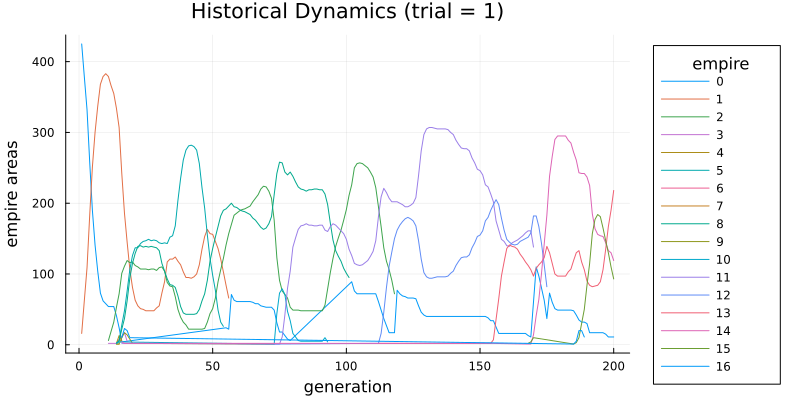

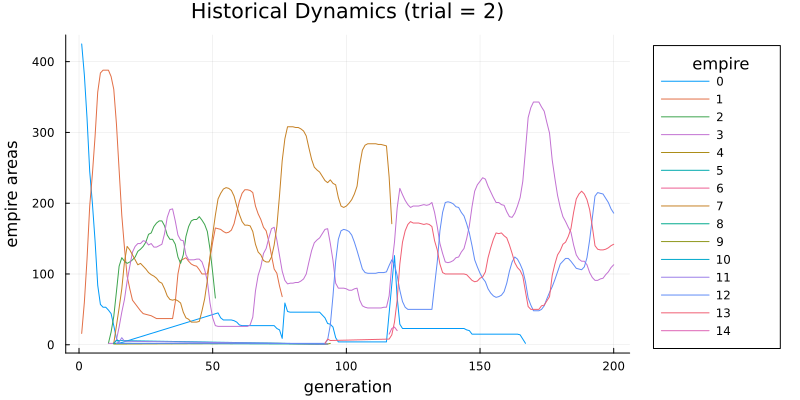

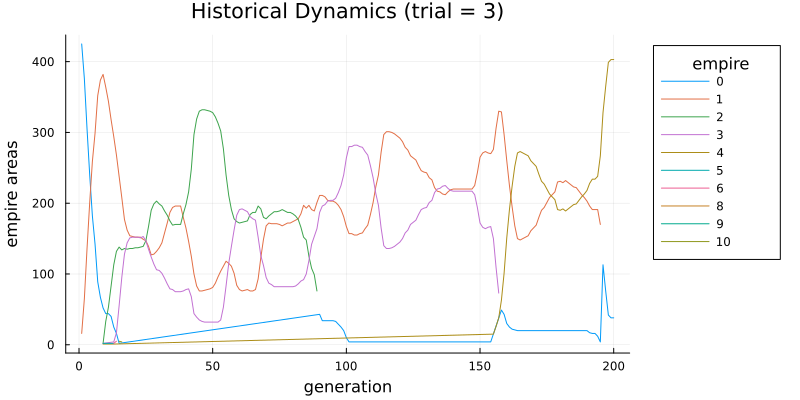

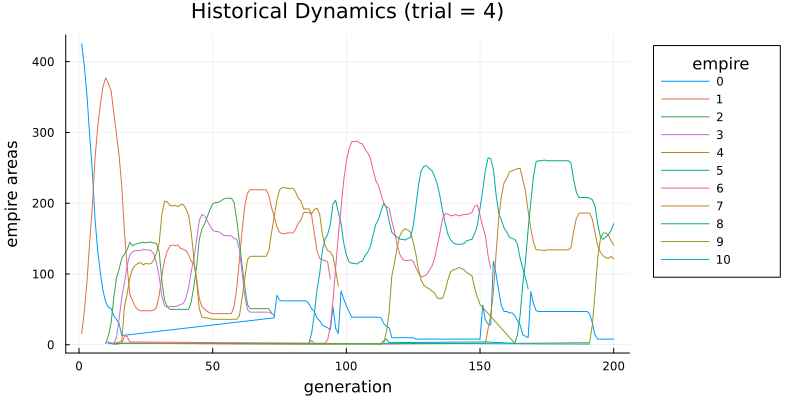

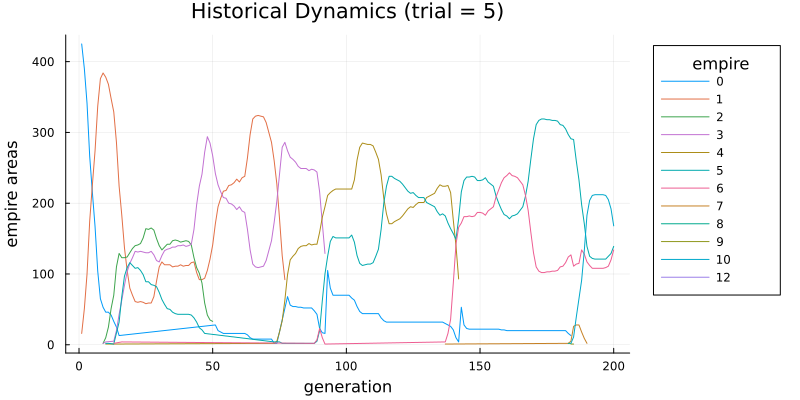

In [16]:
for trial in 1:5
    empire_dynamics(title = "Historical Dynamics (trial = $trial)")
end

- The plot above shows the oscillatory dynamics that we were hoping for, and which resemble real world historical dynamics.
- No empire dominates the entire time period.
- Empire 1 soon collapses making way for new empires.
- Some of these collapse very quickly, others persist for several generations.
- Even by the final generation here, empires continue to rise and fall, and would continue to do so if we extended the simulation further.

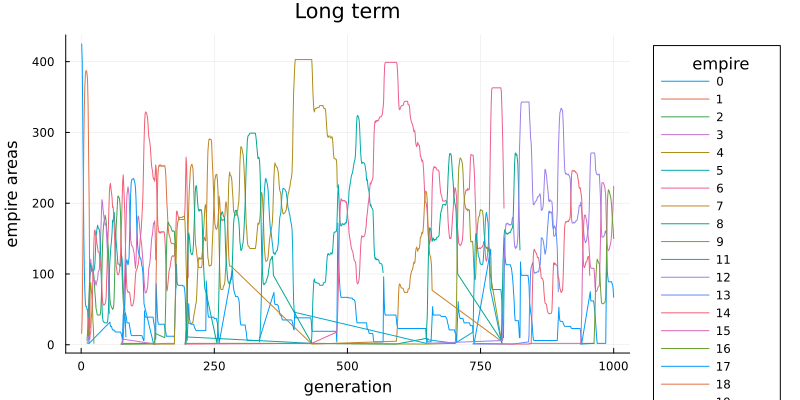

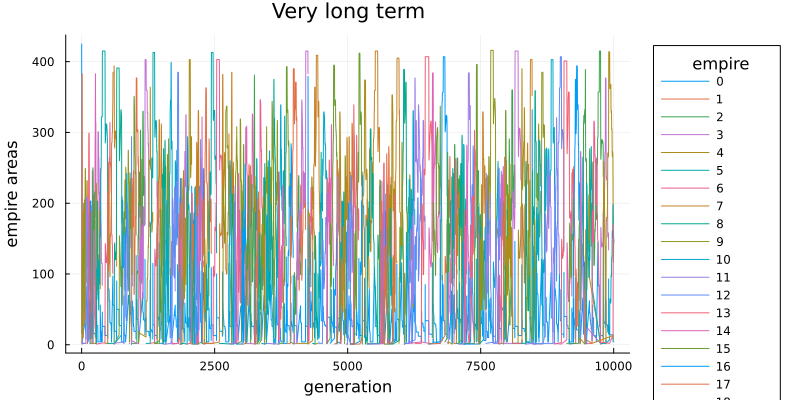

In [17]:
empire_dynamics(t_max = 10^3, title = "Long term")
empire_dynamics(t_max = 10^4, title = "Very long term")

- デフォルトパラメータでは、シミュレーション期間を伸ばしても収束は起きない。

### 2. 辺境・中心の効果

$h$: the constant which determines how quickly power declines with distance from the empire centre.

Increase distance penalty (h: 2.0 → 1.0)

- 帝国の中心部からの距離に応じてグループのパワーが減りやすくなる。
- → 辺境のグループのパワーが減る。
- → 大規模な帝国が生まれにくくなる。
- → 似たようなサイズの小規模帝国が併存・乱立する。
- → 盛衰サイクルが次第になくなり5程度の帝国の共存状態に収束する。

(小数の帝国の共存状態は面白い)

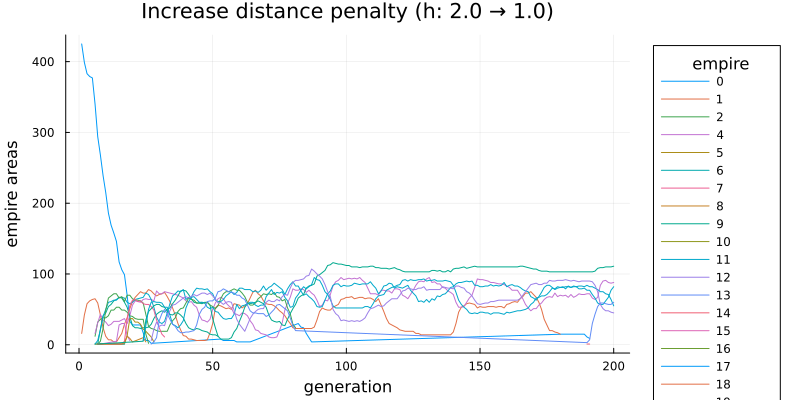

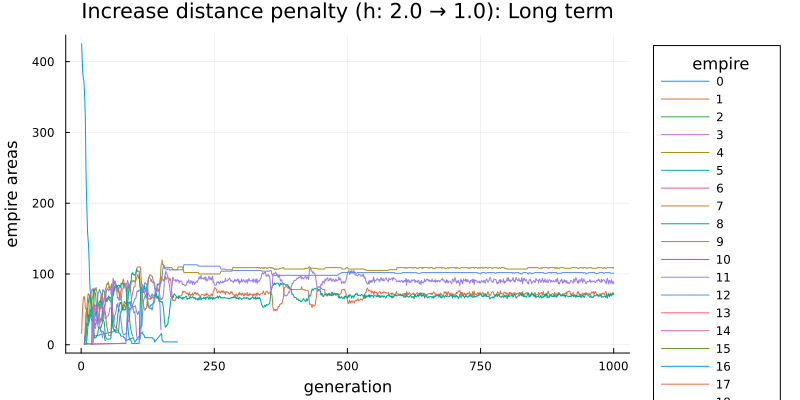

In [18]:
empire_dynamics(h = 1.0, title = "Increase distance penalty (h: 2.0 → 1.0)")
empire_dynamics(h = 1.0, t_max = 10^3, title = "Increase distance penalty (h: 2.0 → 1.0): Long term")

Reduce distance penalty (h: 2.0 → 3.0)

- 帝国の中心部から離れても、グループのパワーは減りにくい。
- → 巨大な帝国ができやすく、1国が世界を簡単に制覇する。
- → 国境がなくなることにより、アサビーヤが減りやすくなる。
- → 全グループが帝国から脱退する。

(あまり現実的ではない。モデルを修正して、全グループが0であっても、そこから帝国が新たに生まれる様にしたい。)

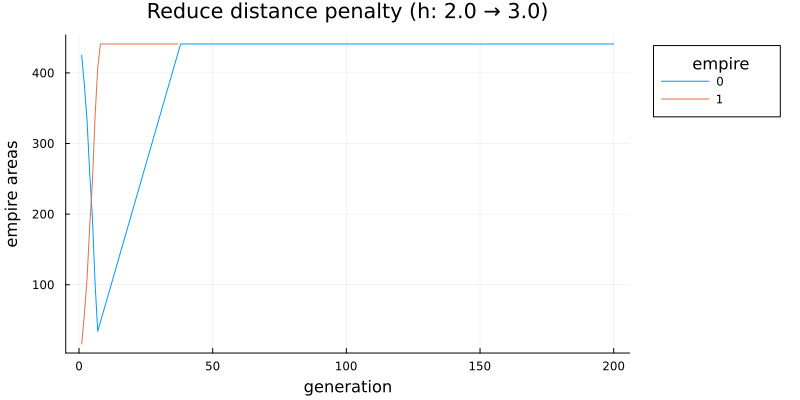

In [19]:
empire_dynamics(h = 3.0, title = "Reduce distance penalty (h: 2.0 → 3.0)")

### 3. アサビーヤの効果

- 国境付近でのアサビーヤの向上が全くなく、中心部でのアサビーヤの低下が全くない場合、最初に一定の領域を占めている帝国が、何の抵抗もなく世界を制覇する。
- 少しでも辺境・中心でのアサビーヤの変化があれば、帝国1が支配を続けるのは難しく、複数の帝国の発生・維持が可能となる。

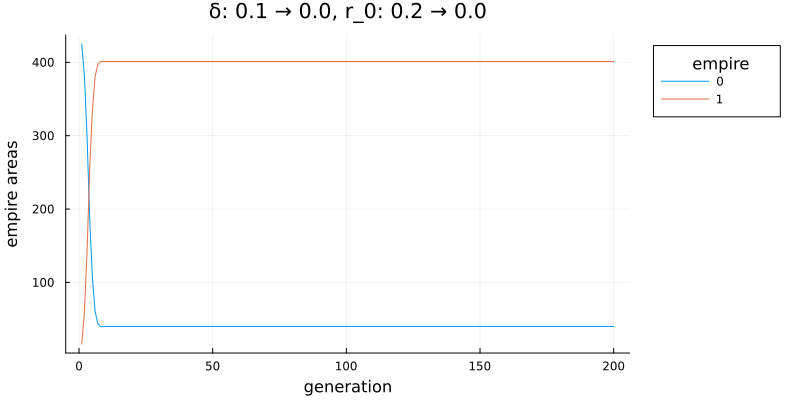

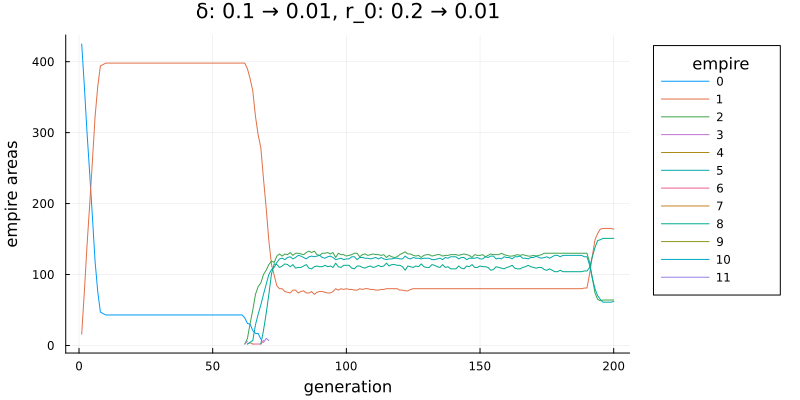

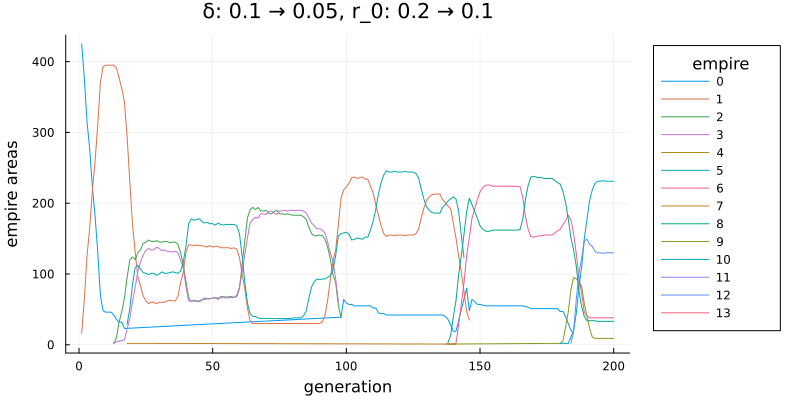

In [20]:
# r_0: increase asabiya according to r_0
# δ: decrease asabiya according to δ
empire_dynamics(δ = 0.0, r_0 = 0.0, title = "δ: 0.1 → 0.0, r_0: 0.2 → 0.0")
empire_dynamics(δ = 0.01, r_0 = 0.01, title = "δ: 0.1 → 0.01, r_0: 0.2 → 0.01")
empire_dynamics(δ = 0.05, r_0 = 0.1, title = "δ: 0.1 → 0.05, r_0: 0.2 → 0.1")

### 4. グループ間闘争の効果

- $δ_P$ の値が大きければグループ間闘争は起きない。
- グループ間闘争が起きなければ何も起きない。

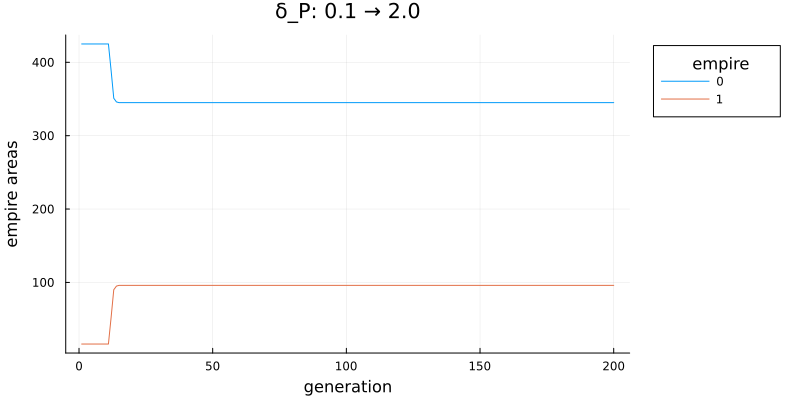

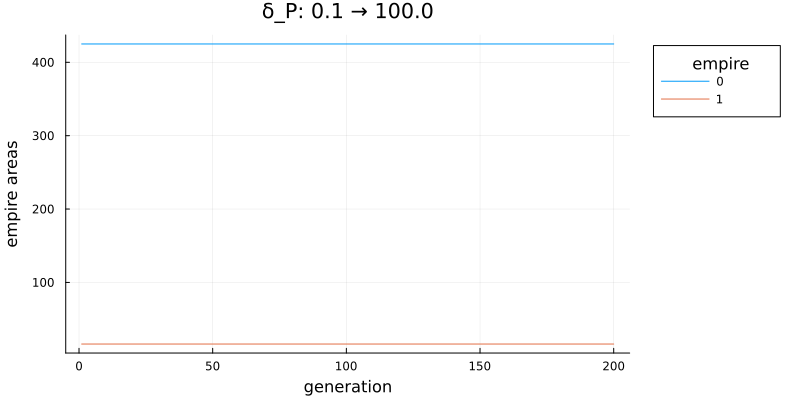

In [21]:
# δ_P: threshold for difference in power between attacker and defender
empire_dynamics(δ_P = 2.0, title = "δ_P: 0.1 → 2.0")
empire_dynamics(δ_P = 100.0, title = "δ_P: 0.1 → 100.0")

- As Turchin (2003) himself points out (p.71), we should be wary of accepting that a theory is correct just because it generates realistic dynamics.
- Those dynamics may be consistent with many other theories comprising different processes.
- However, Turchin goes on to test some of the predictions of the model.
- He shows, for example, that European empires from the years 0 - 1900 almost always emerge in frontier regions, consistent with the model.
- This lends empirical support to Turchin’s theory, and shows how models can guide empirical research.